# Week of 2025.2.17

Last week, I was trying to verify that I had correctly implemented a frictional term dependent on slip. Eric pointed out three issues with my verification. 

1. slip appears to become negative on the right side of the domain, in the first part of the simulation, but velocity is always positive
2. tau_visc is constant but it should vary with velocity. I thought maybe you have tau_visc and tau_slip mislabeled but tau_visc should be proportional to velocity, and neither curve shows that behavior.
3. tau_slip varies non-monotonically in time. It should only decrease, at least if slip only increases.

The **second** challenge was reasonably easy to solve: My method for graphing $\tau_{visc}$ was missing the dependency on velocity. 

Once that issue was resolved we got the following. 

## 1.0 Numerical sim with viscosity tau corrected

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Modify base path for depending on your file structure.
BASE_PATH = "/Users/paxton/git"

# Specify path where .pkl files are located
target_dir = f"{BASE_PATH}/quail_volcano/scenarios/simple_1D_test"
# Specify path for Quail source code
source_dir = f"{BASE_PATH}/quail_volcano/src"
# Change to working directory
os.chdir(target_dir)


# Import quail modules
os.chdir(source_dir)

import meshing.tools as mesh_tools

import numerics.helpers.helpers as helpers
import numerics.timestepping.tools as stepper_tools

import physics.zerodimensional.zerodimensional as zerod
import physics.euler.euler as euler
import physics.navierstokes.navierstokes as navierstokes
import physics.scalar.scalar as scalar
import physics.chemistry.chemistry as chemistry
import physics.multiphasevpT.multiphasevpT as multiphasevpT

import processing.readwritedatafiles as readwritedatafiles
import processing.post as post
import processing.plot as plot
import processing.animate as animate

import solver.DG as DG
import solver.ADERDG as ADERDG
import solver.tools as solver_tools

import time
from IPython.display import HTML
import multiprocessing as mp  
from multidomain import Domain, Observer

os.chdir(target_dir)

## 1.1 Why is slip negative given that our velocity is positive? 

$$ \frac{\partial (\rho q)}{\partial x} + u \frac{\partial (\rho q)}{\partial t} = \rho S$$

It turns out that what we were graphing as "velocity" was actually the **absolute value** of velocity. I resolved that by simply making velocity momentum / rho. The above animation now correctly shows velocity as negative when it is negative 

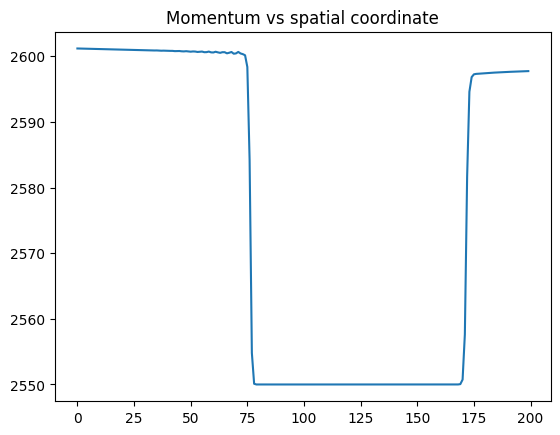

In [ ]:
folder = "slip_variable_addition"
file_prefix = "test_variable_tau"

solver = readwritedatafiles.read_data_file(f"{folder}/{file_prefix}_{5}.pkl")

v = solver.physics.compute_additional_variable("Velocity", solver.state_coeffs, False)
# Get the position of of each nodal points (location corresponding to each entry of slip)
nodal_pts = solver.basis.get_nodes(solver.order)
# Allocate [ne] x [nb, ndims]
x = np.empty((solver.mesh.num_elems,) + nodal_pts.shape)

arhoA = solver.state_coeffs[:,:,solver.physics.get_state_index("pDensityA")]
arhoWt = solver.state_coeffs[:,:,solver.physics.get_state_index("pDensityWt")]
arhoWv = solver.state_coeffs[:,:,solver.physics.get_state_index("pDensityWv")]
arhoC = solver.state_coeffs[:,:,solver.physics.get_state_index("pDensityC")]
arhoM = solver.state_coeffs[:,:,solver.physics.get_state_index("pDensityM")]
arhoF = solver.state_coeffs[:,:,solver.physics.get_state_index("pDensityFm")]

# Get the value of the new state variable.
slip = solver.state_coeffs[:,:,solver.physics.get_state_index("slip")]

rho_mix = arhoA + arhoWv + arhoM


momentum = solver.state_coeffs[:,:,solver.physics.get_momentum_slice()]

plt.title("Momentum vs spatial coordinate")
plt.plot(np.arange(200), momentum.ravel())


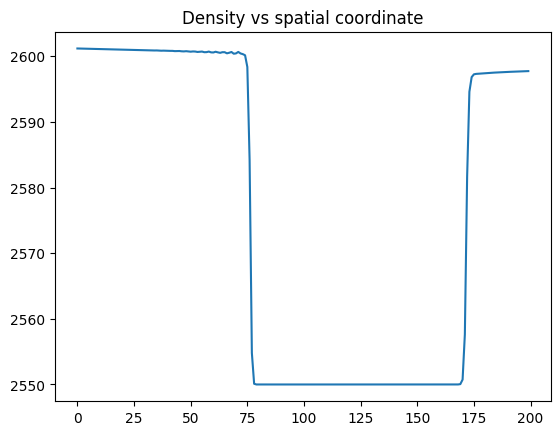

In [4]:
plt.title("Density vs spatial coordinate")
plt.plot(np.arange(200), rho_mix.ravel())

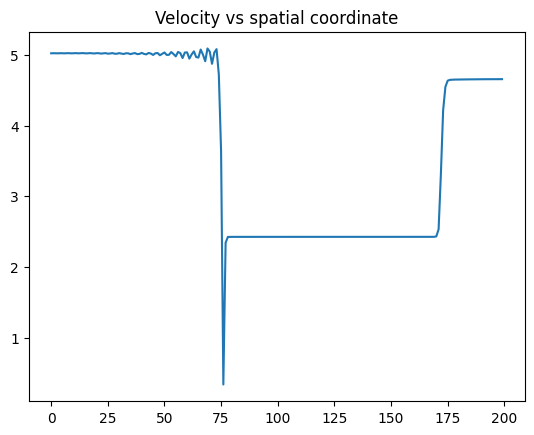

In [5]:
plt.title("Velocity vs spatial coordinate")
plt.plot(np.arange(200), v.ravel())

## 1.2 ICs to keep velocity positive.
Per Eric's suggestion, I modified the initial conditions to result in an initial pressure that is linearly interpolated between the p_L and p_R. As a result, we should never see negative velocity source on the slip conservation equation. 

To map pressure gradient -> melt partial density I used the function:

$\rho(p) = \frac{\rho_0}{1 -\frac{p-p0}{K_T}}$

In practice, this results in a slightly larger pressure than the steady state because `arhoM` is only a partial density rather than the complete density. However, for our purposes it is sufficient. 


In [6]:
ani = animate.animate_conduit_pressure("slip_variable_addition", iterations=100, file_prefix="test_stable_ic")

HTML(ani.to_html5_video())

/Users/paxton/git/quail_volcano/scenarios/simple_1D_test


## 2. Up next we want to introduce a plug by splitting the domain in half

Let's first consider the analytical problem. First the force balance for the plug can be written like so

$$
M \ddot{s} = A (p0 + \Delta p(s(t))) - P_{atm} A - 2 \pi R L \tau(s(t))
$$

We are basically just stating that the force exerted on the plug is the delta in pressure multiplied by the cross section surface area, subtracted by the shear stress multiplied by the surface area of the conduit. 

Equilibrium is defined as 

$$
\begin{align}
0 = P_0 A - P_{atm}A - 2 \pi R L \tau(s)\\
P_0 = p_{atm} + \frac{2 \pi R L \tau_p}{A}
\end{align}
$$

using that condition above, we get a stability equation of:

$$
\begin{align}
M \ddot{s} = A \Delta p(s(t)) + 2 \pi R L (\tau_p - \tau(s)) \\
M \ddot{s} = \frac{-A^2s(t)}{S} + 2 \pi R L (\tau_p - \tau(s))
\end{align}
$$

Where $S$ is known as storage capacity. This is acceleration. So whenever this quantity is > 0 the system is unstable. 

### 2.1 Make 50% of the domain a plug

Now, we want to turn the domain into half melt and half plug. The primary distinction is:
1. The plug should only experience friction from the slip term. 
2. The melt should only experience friction from the viscous fraction. 

To distinguish the plug from the melt, I look at crystal partial density. In the simulation below, I define the plug as anything where the partial crystal density is greater than 50. Because of the diffusion, I believe this results in the plug barrier moving slightly faster than the modeled velocity. 


In [2]:
ani = animate.animate_conduit_pressure("slip_variable_addition", iterations=100, file_prefix="split_domain")

HTML(ani.to_html5_video())

/Users/paxton/git/quail_volcano/scenarios/simple_1D_test


## Open questions
1. A lot of the arrays are of size [200 x 3]. 200 is the number of mesh shells. What does 3 represent? 
2. The added mass effect tells us that the mass should be larger than just the plug. How much larger? 

